In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# sklearn.neighbors.base has been renamed in newer version
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import pandas as pd
from pandas import IndexSlice as idx
import numpy as np
from missingpy import MissForest
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
from math import floor

In [29]:
METHOD = 'bismark' # bismark, bwameth, bsseeker
GROUP = 'IGA+IGN+EDU' # ALL, IGA+IGN+EDU, IGA+IGN, V
READ_ONLY = True # no imputation, read info from a previously saved file

In [26]:
if GROUP == 'V':
    disease = pd.read_excel('../I28_20151015_200DNA_Asetused_väljastusplaadil_1.0_Mikkel.xlsx',
                            sheet_name='200DNA', index_col='Vcode')
    disease = disease['V_plaat'].map(lambda val: val.startswith('Case'))

In [27]:
def read_filtered(method, group):
    return (pd.read_pickle('./{}_cov_filtered_{}.pkl'.format(method, group)),
           pd.read_pickle('./{}_meth_filtered_{}.pkl'.format(method, group)))

def read_full(method):
    return (pd.read_pickle('./{}_cov.pkl'.format(method)),
           pd.read_pickle('./{}_meth.pkl'.format(method)))

def impute(imputer, meth):
    meth = meth.copy()
    
    if GROUP == 'V':
        meth['disease'] = disease
        meth['disease'] = meth['disease'].fillna(False)
        meth = meth.join(pd.get_dummies(meth['disease'], prefix='OH_disease')) # Split categorical data into separate cols
        meth = meth.drop(columns=('disease'))

    meth_imp = imputer.fit_transform(meth)
    df = pd.DataFrame(meth_imp, meth.index, meth.columns)
    return df.filter(regex='^(?!OH_).+$')

In [30]:
cov, meth = read_filtered(METHOD, GROUP)
cov_full, meth_full = read_full(METHOD)

In [31]:
if READ_ONLY:
    meth_mice = pd.read_pickle('./{}_{}_meth_mice.pkl'.format(METHOD, GROUP))
else:
    meth_mice = impute(IterativeImputer(min_value=0.0, max_value=1.0, verbose=1, max_iter=10, sample_posterior=False), meth)
    meth_mice.to_pickle('./{}_{}_meth_mice.pkl'.format(METHOD, GROUP))

[IterativeImputer] Completing matrix with shape (187, 104)
[IterativeImputer] Change: 1.143591827008534, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.47247157886307667, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.2795151259542903, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.17709265259367352, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.11665454137208205, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.08664244359207275, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.07258302203878994, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.06352659700006763, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.05648040082959571, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.05185479921729996, scaled tolerance: 0.001 


C:\Users\simopa\Anaconda3\envs\bio\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [32]:
meth_mice.T

person,EDU509,EDU514,EDU517,EDU520,EDU532,EDU534,EDU536,EDU537,EDU538,EDU539,...,IGN055,IGN056,IGN057,IGN058,IGN060,IGN061,IGN062,IGN064,IGN065,IGN066
site,,,,,,,,,,,,,,,,,,,,,
971,0.441122,0.421045,0.622323,0.905906,0.818611,0.779979,0.504895,0.482370,0.829694,0.654647,...,0.757485,0.457849,0.839729,0.001666,0.732513,0.471941,0.421886,0.769091,0.876023,0.372922
974,0.819785,0.804009,0.884222,0.899064,0.820726,0.723577,0.875594,0.872303,0.767254,0.657051,...,0.734281,0.869186,0.790820,0.818989,0.651806,0.878972,0.786648,0.761818,0.844444,0.791222
975,0.775949,0.737046,0.801943,0.806146,0.709126,0.583087,0.729734,0.791304,0.575257,0.527497,...,0.657934,0.735808,0.711813,0.763333,0.494235,0.742219,0.716449,0.657273,0.711111,0.778173
1088,0.708936,0.724889,0.737769,0.702522,0.738294,0.756708,0.759801,0.755149,0.760534,0.774041,...,0.789855,0.814910,0.760835,0.792857,0.833948,0.792935,0.772000,0.771922,0.807269,0.785714
1779,0.261365,0.252727,0.200913,0.222108,0.239768,0.273886,0.230123,0.250640,0.250741,0.279307,...,0.282084,0.178205,0.291066,0.335269,0.279586,0.150072,0.239340,0.233096,0.166795,0.264815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19860,0.429988,0.435562,0.384041,0.438118,0.408649,0.484863,0.406656,0.404888,0.417616,0.477391,...,0.461765,0.334262,0.479412,0.424920,0.437126,0.407595,0.413605,0.429098,0.393382,0.384158
19862,0.702239,0.694086,0.676624,0.714354,0.710253,0.669298,0.660483,0.665508,0.668482,0.700009,...,0.625551,0.646732,0.750000,0.743344,0.644678,0.656962,0.711565,0.762431,0.720588,0.659406
19863,0.673158,0.669225,0.647573,0.662377,0.659377,0.657723,0.648607,0.650963,0.657802,0.695864,...,0.640235,0.694019,0.694118,0.682641,0.669162,0.636709,0.676190,0.626151,0.729779,0.706931


In [34]:
if READ_ONLY:
    meth_forest2 = pd.read_pickle('./{}_{}_meth_forest2.pkl'.format(METHOD, GROUP))
else:
    meth_forest2 = impute(IterativeImputer(min_value=0.0, max_value=1.0, verbose=1, max_iter=10,
                                                  estimator=RandomForestRegressor(n_estimators=100)), meth)
    meth_forest2.to_pickle('./{}_{}_meth_forest2.pkl'.format(METHOD, GROUP))

[IterativeImputer] Completing matrix with shape (187, 104)
[IterativeImputer] Change: 0.8380728144555176, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.5994194439781662, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.35226739749905167, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.34832410760715343, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.2846268694163292, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.25872639801988684, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.24197464087802859, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.235248234915826, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.2431939889985662, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.32547532775883703, scaled tolerance: 0.001 


C:\Users\simopa\Anaconda3\envs\bio\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [35]:
if READ_ONLY:
    meth_forest = pd.read_pickle('./{}_{}_meth_forest.pkl'.format(METHOD, GROUP))
else:
    meth_forest = impute(MissForest(), meth)
    meth_forest.to_pickle('./{}_{}_meth_forest.pkl'.format(METHOD, GROUP))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


In [36]:
# Aggregate coverage, meth and imputed meth into a single df (using the original unfiltered dataset)
def get_comp(cov_full, meth_full, meth_filtered, meth_imputed):
    meth_imputed_only = {}
    sites = meth_filtered.columns
    
    for imputer, meth_imputed_df in meth_imputed.items():
        meth_imputed_only[imputer] = meth_imputed_df.where(meth_filtered.isna())

    dfs = []

    for person in meth_filtered.index:
        cols = [cov_full.loc[person, sites], meth_full.loc[person, sites]]

        for meth_imputed_only_df in meth_imputed_only.values():
            cols.append(meth_imputed_only_df.loc[person, sites])

        df = pd.concat(cols, axis='columns')
        df.columns = pd.MultiIndex.from_product([[person], ['cov', 'meth'] + list(meth_imputed.keys())], names=['person', 'value'])
        dfs.append(df)
    
    df = pd.concat(dfs, axis='columns')
    return df

# Calculate imputation errors
def get_stats(cov_full, meth_full, meth_filtered, meth_imputed):
    sites = meth_filtered.columns
    dfs = {imputer: pd.DataFrame() for imputer in meth_imputed}
    dfs_common = pd.DataFrame()
    df = pd.DataFrame()

    for site in sites:
        actual_meth = meth_full[site]
        imputed_meth_site = pd.DataFrame()
        imputed_cov = cov_full[site].where(meth_filtered[site].isna())
        imputed_count = actual_meth.where(meth_filtered[site].isna()).count()

        # See below for explanation
        data = {'count': imputed_count, 'imput_cov_mean': imputed_cov.mean(),
                    'imput_cov_std': imputed_cov.std()}
        dfs_common = dfs_common.append(pd.Series(data, name=site))

        for imputer, meth_imputed_df in meth_imputed.items():
            meth_imputed_only = meth_imputed_df.where(meth_filtered.isna()) # Actually imputed values
            imputed_meth = meth_imputed_only[site]
            imputed_meth_site[imputer] = imputed_meth.dropna()
            imputed_meth_cmp = imputed_meth.where(actual_meth.notna())

            if imputed_meth_cmp.count() == 0:
                continue

            meth_diff = abs(imputed_meth_cmp - actual_meth)

            """
            These are calculated using only the imputed values that have a comparable entry in meth_full.
                meth_diff_* - abs difference between reported methylation and imputed methylation per site
                count - number of persons per site, used to calculate these numbers
                imput_cov_* - read coverage for the values used in meth_diff_* calculations
            """
            data = {'meth_diff_mean': meth_diff.mean(), 'meth_diff_std': meth_diff.std()}
            dfs[imputer] = dfs[imputer].append(pd.Series(data, name=site))
        
        """
        These are calculated using all imputed values.
        For each site:
            * find the mean of imputation values over all imputers for every person
            * for each imputer, find abs(value - avg) for every person
            * find the average over all persons
        """
        imputer_mean_diff_from_mean = abs(imputed_meth_site.sub(imputed_meth_site.mean(axis='columns'), axis='index')).mean()
        df = df.append(pd.Series(imputer_mean_diff_from_mean, name=site))

    return df.dropna(how='all'), dfs_common.join(pd.concat(dfs, axis='columns')).sort_values('imput_cov_mean', ascending=False)

In [38]:
comp = get_comp(cov_full, meth_full, meth, {'mice': meth_mice,'forest': meth_forest,'forest2': meth_forest2})

In [39]:
#excluded_persons = ['IGA002', 'IGN021', 'IGN024', 'IGN025']
imp_methods = ['mice', 'forest', 'forest2']
excluded_persons = []
cov_group_size = 50

data = comp[comp.columns[comp.columns.map(lambda x: x[0] not in excluded_persons and not x[0].startswith('V'))]]

for imp_method in imp_methods:
    col_name = '{}_imp_diff'.format(imp_method)
    imp_diffs = data.loc[:, idx[:, 'meth']].rename(columns={'meth':col_name}) - data.loc[:, idx[:, imp_method]].rename(columns={imp_method:col_name})
    data = data.join(imp_diffs)

cov_group = data.loc[:, idx[:, 'cov']].rename(columns={'cov':'cov_group'})\
    .applymap(lambda cov: '{}-{}'.format(floor((cov-1)/cov_group_size)*cov_group_size+1, (1+floor((cov-1)/cov_group_size))*cov_group_size))
data = data.join(cov_group)
data = data.reindex(columns=sorted(data.columns))
data

person EDU509                                                                  \
value     cov  cov_group    forest   forest2 forest2_imp_diff forest_imp_diff   
site                                                                            
971      5953  5951-6000       NaN       NaN              NaN             NaN   
974      5954  5951-6000       NaN       NaN              NaN             NaN   
975      5954  5951-6000       NaN       NaN              NaN             NaN   
1088        0      -49-0  0.710710  0.711656              NaN             NaN   
1779        0      -49-0  0.252463  0.255365              NaN             NaN   
...       ...        ...       ...       ...              ...             ...   
19860       0      -49-0  0.425045  0.446318              NaN             NaN   
19862       0      -49-0  0.695387  0.704040              NaN             NaN   
19863       0      -49-0  0.667407  0.667903              NaN             NaN   
19864       0      -49-0  0.673637  0.671397              NaN             NaN   
19866       0      -49-0  0.677749  0.672653              NaN             NaN   

person                                   EDU514  ...        IGN065 IGN066  \
value       meth      mice mice_imp_diff    cov  ... mice_imp_diff    cov   
site                                             ...                        
971     0.441122       NaN           NaN   6985  ...           NaN    842   
974     0.819785       NaN           NaN   6985  ...           NaN    843   
975     0.775949       NaN           NaN   6986  ...           NaN    843   
1088         NaN  0.708936           NaN      0  ...      0.038885    420   
1779         NaN  0.261365           NaN      0  ...     -0.032775    540   
...          ...       ...           ...    ...  ...           ...    ...   
19860        NaN  0.429988           NaN      0  ...           NaN    505   
19862        NaN  0.702239           NaN      0  ...           NaN    505   
19863        NaN  0.673158           NaN      0  ...           NaN    505   
19864        NaN  0.687945           NaN      0  ...           NaN    505   
19866        NaN  0.670933           NaN      0  ...           NaN    505   

person                                                                      \
value  cov_group forest forest2 forest2_imp_diff forest_imp_diff      meth   
site                                                                         
971      801-850    NaN     NaN              NaN             NaN  0.372922   
974      801-850    NaN     NaN              NaN             NaN  0.791222   
975      801-850    NaN     NaN              NaN             NaN  0.778173   
1088     401-450    NaN     NaN              NaN             NaN  0.785714   
1779     501-550    NaN     NaN              NaN             NaN  0.264815   
...          ...    ...     ...              ...             ...       ...   
19860    501-550    NaN     NaN              NaN             NaN  0.384158   
19862    501-550    NaN     NaN              NaN             NaN  0.659406   
19863    501-550    NaN     NaN              NaN             NaN  0.706931   
19864    501-550    NaN     NaN              NaN             NaN  0.629703   
19866    501-550    NaN     NaN              NaN             NaN  0.661386   

person                     
value  mice mice_imp_diff  
site                       
971     NaN           NaN  
974     NaN           NaN  
975     NaN           NaN  
1088    NaN           NaN  
1779    NaN           NaN  
...     ...           ...  
19860   NaN           NaN  
19862   NaN           NaN  
19863   NaN           NaN  
19864   NaN           NaN  
19866   NaN           NaN  

[104 rows x 1683 columns]

In [40]:
errs_avg_all = {}
errs_all_all = {}

for imp_method in imp_methods:
    imp_diff = '{}_imp_diff'.format(imp_method)
    imp_diffs_by_cov = defaultdict(list)

    for person in data.columns.get_level_values('person').unique():
        imp_diffs = data[person][data[(person, imp_diff)].notna()]

        for site in imp_diffs.index:
            imp_diffs_by_cov[imp_diffs['cov_group'][site]].append(imp_diffs[imp_diff][site])

    errs_avg = pd.DataFrame()
    errs_all = pd.DataFrame()

    for cov_group in sorted(imp_diffs_by_cov, key=lambda group: int(group.split('-')[0])):
        imp_diffs = imp_diffs_by_cov[cov_group]
        # Aggregate imputation differences per coverage range
        errs_avg = errs_avg.append(pd.Series({'RMSE': np.sqrt(np.sum(np.square(imp_diffs)) / len(imp_diffs)),
                                              'Count': len(imp_diffs),
                                              'MAE': np.mean(np.abs(imp_diffs)),
                                              'Read depth': cov_group}, name=cov_group))
        errs_all = errs_all.append(pd.DataFrame({'AE': np.abs(imp_diffs), 'Read depth': cov_group}))
        
    errs_avg_all[imp_method] = errs_avg
    errs_all_all[imp_method] = errs_all

In [41]:
errs_avg_all['mice']

,RMSE,Count,MAE,Read depth
1-50,0.255511,110.0,0.178625,1-50
51-100,0.111837,82.0,0.076068,51-100
101-150,0.062249,69.0,0.050084,101-150
151-200,0.059418,144.0,0.043945,151-200
201-250,0.058582,153.0,0.041498,201-250
251-300,0.047617,126.0,0.037709,251-300


<IPython.core.display.Javascript object>


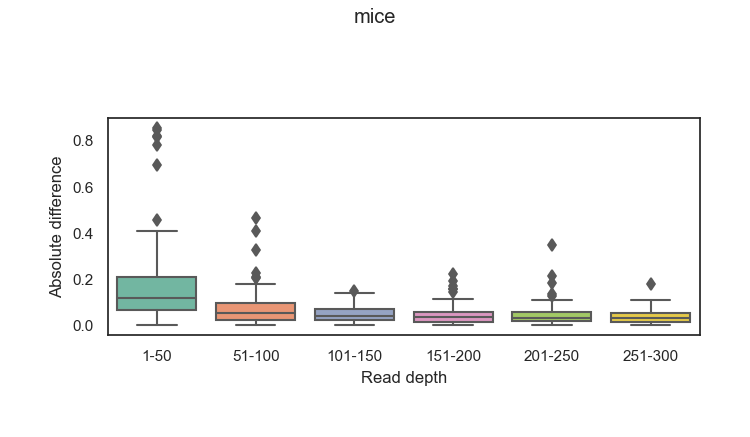

<IPython.core.display.Javascript object>


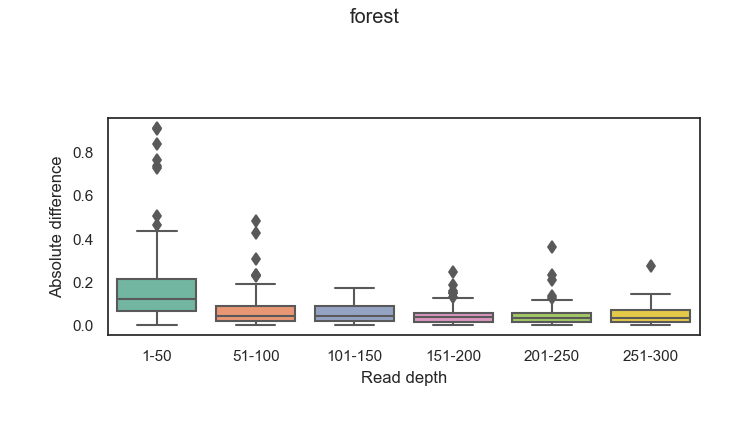

<IPython.core.display.Javascript object>


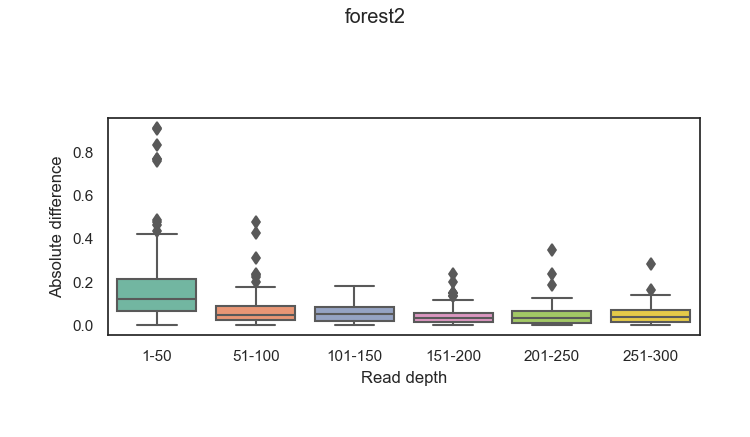

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

sns.set()
sns.set_palette("husl")
sns.set_style("white")
sns.set_context("paper")
colors = sns.color_palette()
colors_dark = sns.hls_palette(8, l=0.5)

for imp_method in imp_methods:
    errs_avg = errs_avg_all[imp_method]
    errs_all = errs_all_all[imp_method]
    
    fig, axes = plt.subplots(1, 1, figsize=(6,3.5))
    fig.suptitle(imp_method)
    errs_avg['Mean absolute difference'] = errs_avg['MAE']
    errs_all['Absolute difference'] = errs_all['AE']
    sns.boxplot(ax=axes, x=errs_all['Read depth'], y=errs_all['Absolute difference'], palette='Set2')
    #sns.scatterplot(x=errs_avg['Read depth'], y=errs_avg['MAE'], size=errs_avg['Count'].astype(int), sizes=(10, 100))
    plt.tight_layout(pad=3)
    
    if not READ_ONLY:
        fig.savefig('../fig/{}_imp_diff.png'.format(imp_method), dpi=200)

In [43]:
cmp, diffs = get_stats(cov_full, meth_full, meth, {'mice': meth_mice})

C:\Users\simopa\Anaconda3\envs\bio\lib\site-packages\pandas\core\frame.py:9126: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


In [44]:
diffs

,count,imput_cov_mean,imput_cov_std,"(mice, meth_diff_mean)","(mice, meth_diff_std)"
18966,1.0,191.0,NaN,0.015433,NaN
18964,1.0,191.0,NaN,0.221515,NaN
18963,1.0,191.0,NaN,0.058008,NaN
18960,1.0,191.0,NaN,0.193861,NaN
18968,1.0,191.0,NaN,0.089434,NaN
...,...,...,...,...,...
13286,0.0,NaN,NaN,NaN,NaN
13287,0.0,NaN,NaN,NaN,NaN
13288,0.0,NaN,NaN,NaN,NaN
13290,0.0,NaN,NaN,NaN,NaN


In [45]:
diffs[(diffs['imput_cov_mean'] >= 40) & (diffs['count'] >= 5)].mean()

count                     11.617021
imput_cov_mean            93.422767
imput_cov_std             94.883414
(mice, meth_diff_mean)     0.055420
(mice, meth_diff_std)      0.054351
dtype: float64